# **Simulating a LCDM (Lambda Cold Dark-Matter) Universe**

## **LCDM Implementation Improvements**
In the last notebook, we successfully implementated a basic particle-mesh simulation that represents the evolution of particles based on current cosmological parameters. Here is a overview of the process:

1. ***Gaussian Random Field:***
  - Generation of a GRF using a power spectrum with an Eisenstein-Hu transfer function, which results in an initial density field representing the density contrast (overdensity δ). This δ is a map of initial density fluctuations that will be used to evolve the particles in the simulation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
from scipy.interpolate import RegularGridInterpolator

# Grid params.
N = 256
L = 100
k0 = 2 * np.pi / L

# Cosmological params.
z_start = 99
a = 1 / (1 + z_start)
ns = 0.96
D = 1 / (1 + z_start)
H0 = Planck18.H0.value
H = Planck18.H(z_start).value
A = 2.1e-9
f = Planck18.Om(z_start)**0.55
h = Planck18.h
omega_m = Planck18.Om0
sigma8 = 0.8

print(f"The Hubble parameter at redshift z={z_start}: {H} km/s/Mpc")
print(f"The current Hubble constant (at z=0): {H0} km/s/Mpc")
print(f"The hubble constant scaling factor (just the hubble constant without dimensions): {h}")
print(f"The fundamental wavenumber k0 (largest scale mode), given box size L: {k0} h/Mpc")
print(f"The linear growth factor at initial redshift (z={z_start}): {D}")
print(f"The growth rate of density perturbations at z={z_start}: {f}")
print(f"The present-day matter density parameter Ω_m (at z=0): {omega_m}")
print(f"The present-day sigma_8 parameter (at z=0): {sigma8}")

The Hubble parameter at redshift z=99: 38244.35636301532 km/s/Mpc
The current Hubble constant (at z=0): 67.66 km/s/Mpc
The hubble constant scaling factor (just the hubble constant without dimensions): 0.6766
The fundamental wavenumber k0 (largest scale mode), given box size L: 0.06283185307179587 h/Mpc
The linear growth factor at initial redshift (z=99): 0.01
The growth rate of density perturbations at z=99: 0.9829420422520284
The present-day matter density parameter Ω_m (at z=0): 0.30966
The present-day sigma_8 parameter (at z=0): 0.8


In [ ]:
def einsenstein_hu(k, omega_m, h):
  q = k / (omega_m * h**2)
  return (np.log(1 + 2.34 * q) / (2.34 * q)) * (1 + 3.89 * q + (16.1 * q)**2 + (5.46 * q)**3 + (6.71 * q)**4)**(-0.25)

def power_spectrum(k, A, ns, transfer):
  return np.where(k > 0, A * (k ** ns) * (transfer(k)), 0)

def fourier_space(N):
  np.random.seed(43)
  # Setting up the 3D coordinate grids in Fourier Space:
  k_coords = np.fft.fftfreq(N) * N * k0
  kx, ky, kz = np.meshgrid(k_coords, k_coords, k_coords, indexing='ij')
  k2 = kx**2 + ky**2 + kz**2
  k = np.sqrt(k2) # Magnitude of k vector.
  return kx, ky, kz, k, k2

def grf_setup(N, variance):
  # Complex Gaussian noise: real and imaginary parts ~ N(0, sqrt(P(k)/2))
  field_k = (np.random.normal(0, 1, (N, N, N)) +
            1j * np.random.normal(0, 1, (N, N, N))) * np.sqrt(variance / 2)
  # Ensure Hermitian symmetry for real output (field_k[-k] = conj(field_k[k]))
  field_k[tuple(-i % N for i in np.indices((N, N, N)))] = np.conj(field_k)
  field_k[0, 0, 0] = 0
  field_k *= D
  return field_k

kx, ky, kz, k, k2 = fourier_space(N)
transfer = lambda k: einsenstein_hu(k, omega_m, h)
variance = power_spectrum(k, A, ns, transfer)

field_k = grf_setup(N, variance)
field_real = np.fft.ifftn(field_k)
initial_density_field = np.real(field_real)

# Normalizing initial density field to get density contrast by scaling it by our
# target_std/current_std so that its variance is not too small and its correctly scaled
# to match the current amplitude.
current_std = np.std(initial_density_field)
print(f"Current std of density field: {current_std}")

target_std = sigma8 * D
initial_density_field *= target_std / current_std
print(f"New std of density field: {np.std(initial_density_field)}")

<ipython-input-2-f797f10392e2>:3: RuntimeWarning: invalid value encountered in divide
  return (np.log(1 + 2.34 * q) / (2.34 * q)) * (1 + 3.89 * q + (16.1 * q)**2 + (5.46 * q)**3 + (6.71 * q)**4)**(-0.25)


Current std of density field: 2.2545713719052877e-12
New std of density field: 0.008000000000000007


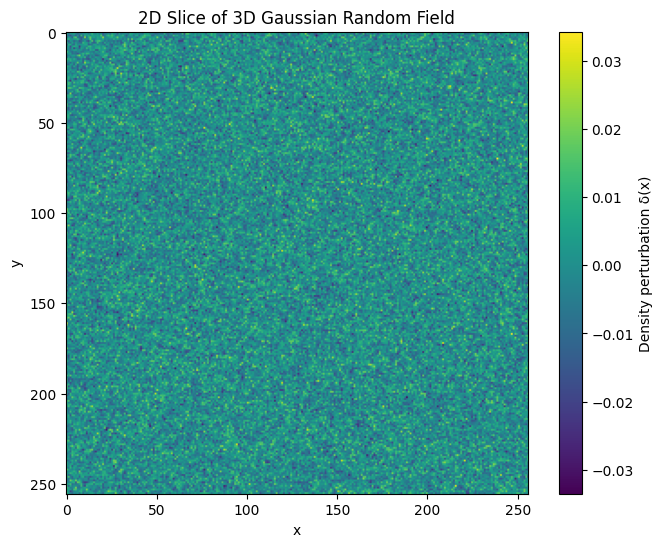

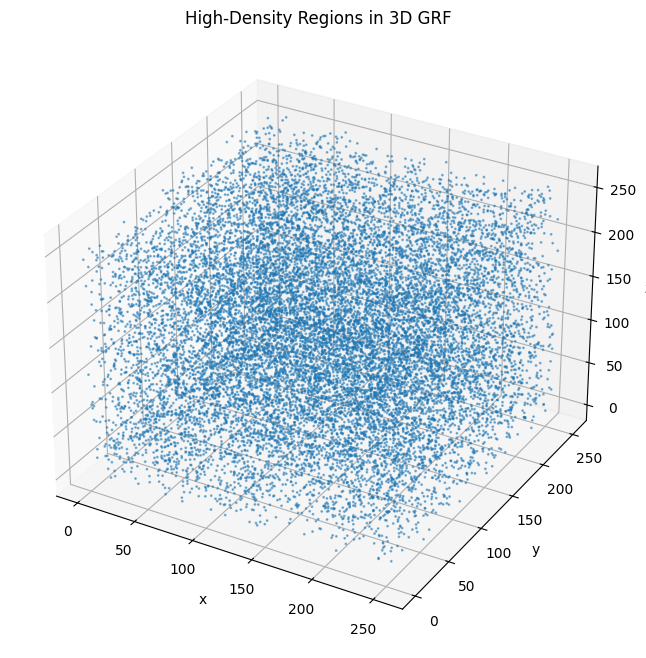

Mean density: -5.61159327555974e-21
Standard deviation: 0.008000000000000007
Min density: -4.386e-02, Max density: 4.280e-02


In [ ]:

# Visualization of the density field, a 2D slice.
plt.figure(figsize=(8, 6))
plt.imshow(initial_density_field[N//2, :, :], cmap='viridis')
plt.colorbar(label='Density perturbation δ(x)')
plt.title('2D Slice of 3D Gaussian Random Field')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Also, a 3D scatter plot of the high density regions.
threshold = np.percentile(initial_density_field, 99.9)  # Top 1% density
high_density = np.where(initial_density_field > threshold)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(high_density[0], high_density[1], high_density[2], s=1, alpha=0.5)
ax.set_title('High-Density Regions in 3D GRF')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

# Finally, lets print some stats.
print(f"Mean density: {np.mean(initial_density_field)}")
print(f"Standard deviation: {np.std(initial_density_field)}")
print(f"Min density: {np.min(initial_density_field):.3e}, Max density: {np.max(initial_density_field):.3e}")

2. ***Zel'dovich Approximation:***
  - Usage of the Zel'dovich Approximation for the computation of the initial displacements Ψ and velocities:

    - Takes our density contrast δ and computes the gravitational potential Φ and subsequent displacement field(s) Ψ. Use Ψ to get our displaced particles' positions and their velocities.

In [ ]:
def zeldovich_positions(N_part=N):
  displacements = zeldovich(initial_density_field)
  grid_1d = np.linspace(0, L, N_part, endpoint=False)
  qx, qy, qz = np.meshgrid(grid_1d, grid_1d, grid_1d, indexing='ij')
  positions = np.stack([qx, qy, qz], axis=-1).reshape(-1, 3)

  # Interpolating the displacements to the particle grid if N_part != N.
  if N_part != N:
    grid_points = np.linspace(0, L, N, endpoint=False)
    interp = RegularGridInterpolator((grid_points, grid_points, grid_points),
                                    displacements.transpose(1, 2, 3, 0))
    disp_at_q = interp(positions)
  else:
    disp_at_q = displacements.transpose(1, 2, 3, 0).reshape(-1, 3)

  positions += disp_at_q
  return positions

def zeldovich_velocities(N_part=N):
  displacements = zeldovich(initial_density_field)
  # Interpolating the displacements to the particle grid if N_part != N
  if N_part != N:
    grid_points = np.linspace(0, L, N, endpoint=False)
    interp = RegularGridInterpolator((grid_points, grid_points, grid_points),
                                    displacements.transpose(1, 2, 3, 0))
    disp_at_q = interp(zeldovich_positions(N_part))
  else:
    disp_at_q = displacements.transpose(1, 2, 3, 0).reshape(-1, 3)

  velocities = a * H * f * disp_at_q
  return velocities

def zeldovich_one_direction(potential_k, k_dir):
  displacement_k = -1j * k_dir * potential_k
  displacement_real = np.real(np.fft.ifftn(displacement_k))
  return displacement_real

def zeldovich(density_field):
  density_k = np.fft.fftn(density_field)
  kx, ky, kz, k, k2 = fourier_space(N)
  k2[0,0,0] = 1.0      # Avoiding division by 0 at k=0.

  # Gravitational potential.
  potential_k = -density_k / k2
  potential_k[0,0,0] = 0    # Mean displacement = 0.

  displacements = np.zeros((3, N, N, N))
  displacements[0] = zeldovich_one_direction(potential_k, kx)
  displacements[1] = zeldovich_one_direction(potential_k, ky)
  displacements[2] = zeldovich_one_direction(potential_k, kz)
  return displacements

# This just calls our respective positions and velocities functions.
positions = zeldovich_positions()
velocities = zeldovich_velocities()
print(f"Positions shape: {positions.shape}")
print(f"Velocities shape: {velocities.shape}")

Positions shape: (16777216, 3)
Velocities shape: (16777216, 3)


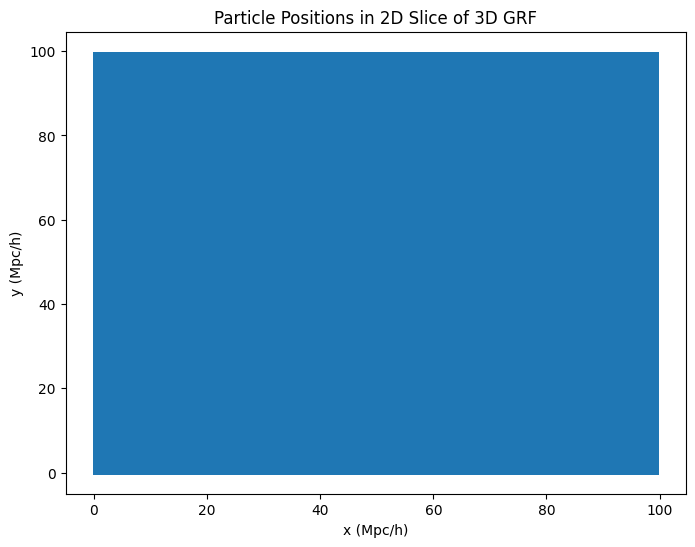

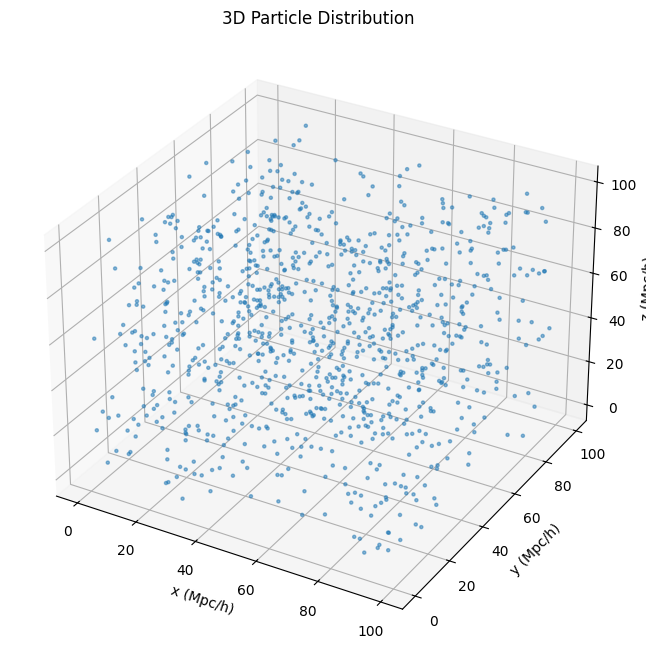

Scale factor a = 0.0100
Growth factor D = 0.0100
Hubble parameter H(a) = 38244.36 km/s/Mpc (proper)
Mean displacement: 1.865e-03 Mpc/h
Max displacement: 7.233e-03 Mpc/h
Mean velocity: 0.7013 km/s
Max velocity: 2.7191 km/s
Grid spacing h = 0.391 Mpc/h
Max displacement as fraction of h: 1.852e-02


In [ ]:
# Visualizations:
percentage = 0.1
num_rows = int(percentage * positions.shape[0])
plt.figure(figsize=(8, 6))
plt.scatter(positions[:, 0], positions[:, 1], s=1, alpha=0.1)
plt.title(f"Particle Positions in 2D Slice of 3D GRF")
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

subset = np.random.choice(len(positions), 1000, replace=False)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[subset, 0], positions[subset, 1], positions[subset, 2], s=5, alpha=0.5)
ax.set_title(f"3D Particle Distribution")
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_zlabel('z (Mpc/h)')
plt.show()

print(f"Scale factor a = {a:.4f}")
print(f"Growth factor D = {D:.4f}")
print(f"Hubble parameter H(a) = {H:.2f} km/s/Mpc (proper)")

# Should be a small magnitude, ranging from 0.1 or 0.01.
print(f"Mean displacement: {np.mean(np.sqrt(np.sum(zeldovich(initial_density_field)**2, axis=0))):.3e} Mpc/h")
print(f"Max displacement: {np.max(np.sqrt(np.sum(zeldovich(initial_density_field)**2, axis=0))):.3e} Mpc/h")
print(f"Mean velocity: {np.mean(np.sqrt(np.sum(velocities**2, axis=1))):.4f} km/s")
print(f"Max velocity: {np.max(np.sqrt(np.sum(velocities**2, axis=1))):.4f} km/s")

# Compare to grid spacing.
h = L / N
print(f"Grid spacing h = {h:.3f} Mpc/h")
print(f"Max displacement as fraction of h: {np.max(np.sqrt(np.sum(zeldovich(initial_density_field)**2, axis=0))) / h:.3e}")

3. **CIC (Cloud-In-Cell) Interpolation:**
- Mapping of our particles displaced positions onto a new density grid via the CIC interpolation technique:
  - Assignment of particles' masses to a new density grid, via mass distribution of each of the particles' 8 neighboring grid points using trilinear interpolation. Results in a new density contrast δ.
  - This interpolation technique is the essense of particle-mesh simulations, as it allows us to map the particles' new positions on a grid based on the gravitational acceleration(s) acting upon them. This is the grid to be used for subsequent positions and velocity updates at each timestep of the simulation.

In [ ]:
def cic_initial(positions, N, L):
  # Simulation's grid spacing initialization, followed by wrapping of the positions
  # to handle periodic boundary conditions.
  h = L/N
  wrapped_pos = positions % L

  # Usage of integer floor function on particle coords to get the patent cell indices.
  # Computation of normalized distances and subsequent weights for each dimension.
  xp, yp, zp = wrapped_pos[:, 0]/h, wrapped_pos[:, 1]/h, wrapped_pos[:, 2]/h
  xc, yc, zc = xp.astype(int), yp.astype(int), zp.astype(int)
  dx, dy, dz = xp-xc, yp-yc, zp-zc
  tx, ty, tz = 1-dx, 1-dy, 1-dz

  # Usage of weights for each dimension for computation of the weights for the 8 neighboring
  # grid points. These represents the contributions of each weight to their respective points.
  w000 = tx * ty * tz
  w100 = dx * ty * tz
  w010 = tx * dy * tz
  w001 = tx * ty * dz
  w110 = dx * dy * tz
  w011 = tx * dy * dz
  w101 = dx * ty * dz
  w111 = dx * dy * dz

  # Initialization of new density grid, as well as grid's indicies using our parent cell indices.
  # Making sure we take into account periodicity.
  density_grid = np.zeros((N, N, N))
  i0, i1 = xc % N, (xc+1) % N
  j0, j1 = yc % N, (yc+1) % N
  k0, k1 = zc % N, (zc+1) % N

  # Particle mass assignment to the its 8 respective neighboring grid points.
  # As of now, lets keep particle's mass to be 1.
  mp = 1
  np.add.at(density_grid, (i0, j0, k0), mp * w000)
  np.add.at(density_grid, (i1, j0, k0), mp * w100)
  np.add.at(density_grid, (i0, j1, k0), mp * w010)
  np.add.at(density_grid, (i0, j0, k1), mp * w001)
  np.add.at(density_grid, (i1, j1, k0), mp * w110)
  np.add.at(density_grid, (i0, j1, k1), mp * w011)
  np.add.at(density_grid, (i1, j0, k1), mp * w101)
  np.add.at(density_grid, (i1, j1, k1), mp * w111)

  # The result is our density grid where each point's value is the total mass
  # assigned to it, based on the weight's contribution at that specific grid point.
  # Remember, the weight is determined by the distance of the particle from that point.
  return density_grid

cic_density_field = cic_initial(positions, N, L)
mean_density = np.mean(cic_density_field)
delta_cic_density_field = cic_density_field / mean_density - 1

# The mean density should be close to 1, since N_part = N
print(f"Mean density from CIC (particles per grid point): {mean_density:.3f}")
print(f"Total mass assigned: {np.sum(cic_density_field):.1f} (should equal N_part^3 = {N**3})")

Mean density from CIC (particles per grid point): 1.000
Total mass assigned: 16777216.0 (should equal N_part^3 = 16777216)


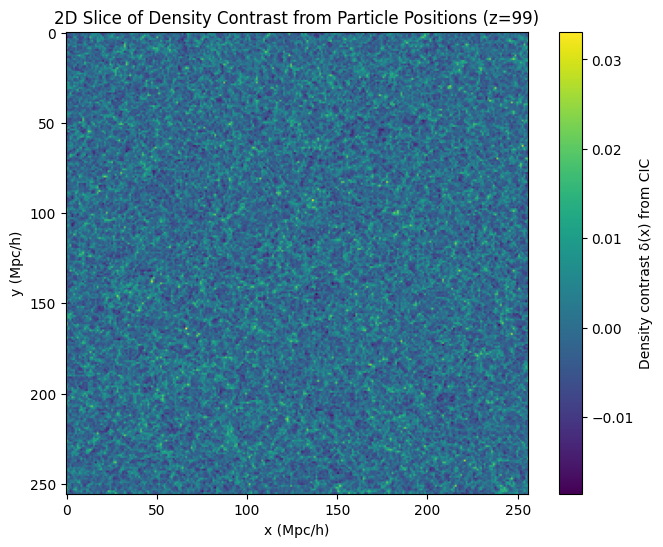

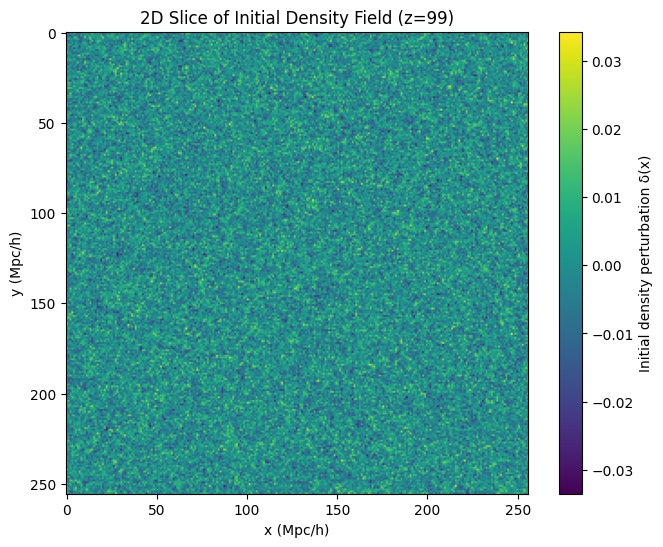

Standard deviation of initial δ: 8.000e-03
Standard deviation of CIC δ: 5.278e-03


In [ ]:
# Visualizations:
# Plot a 2D slice of the CIC density contrast
plt.figure(figsize=(8, 6))
plt.imshow(delta_cic_density_field[N//2, :, :], cmap='viridis')
plt.colorbar(label='Density contrast δ(x) from CIC')
plt.title('2D Slice of Density Contrast from Particle Positions (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Plot the initial density field for comparison
plt.figure(figsize=(8, 6))
plt.imshow(initial_density_field[N//2, :, :], cmap='viridis')
plt.colorbar(label='Initial density perturbation δ(x)')
plt.title('2D Slice of Initial Density Field (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Compare statistics
print(f"Standard deviation of initial δ: {np.std(initial_density_field):.3e}")
print(f"Standard deviation of CIC δ: {np.std(delta_cic_density_field):.3e}")

4. ***New Gravitational Φ and Ψ from CIC Density Field:***
- Using the new δ, we compute the new gravitational potential and forces. In this case, we denote the displacement field(s) Ψ to be the gravitational forces (acceleration fields) instead.
  - This process is the same as in the Zel'dovich Approx step.
  - In this case, we denote the displacement field(s) Ψ to be the gravitational forces (acceleration fields) instead. This acceleration will be used to update the particles and velocities at each timestep in the simulation.
- Once these are calculated, we do a new CIC interpolation process in order to give our particles a tailored acceleration based on their region in the field. Thus, this will be a slightly different process from the initial CIC interpolation step:
  - Initial CIC does particle mass distribution to 8 neighboring grid points on the grid. Can be seen as a 'scattering' of the particle's contribution to each of the points. Thus, a particle-to-grid operation.
  - This CIC will take our new Ψ computed from the initial CIC field and assign them to the particles. Each particle's acceleration is the weighted average of the forces at the 8 neighboring grid points. Can be visualized as a 'gathering' of the grid's forces to the particle. Thus, a grid-to-particle operation.

In [ ]:
# To keep it simple, can simply reuse the zeldovich functions to get Φ and Ψ.
def zeldovich_one_direction(potential_k, k_dir):
  displacement_k = -1j * k_dir * potential_k
  displacement_real = np.real(np.fft.ifftn(displacement_k))
  return displacement_real

def zeldovich(density_field):
  density_k = np.fft.fftn(density_field)
  kx, ky, kz, k, k2 = fourier_space(N)
  k2[0,0,0] = 1.0      # Avoiding division by 0 at k=0.

  # Gravitatonal potential.
  potential_k = -density_k / k2
  potential_k[0,0,0] = 0    # Mean displacement = 0.

  displacements = np.zeros((3, N, N, N))
  displacements[0] = zeldovich_one_direction(potential_k, kx)
  displacements[1] = zeldovich_one_direction(potential_k, ky)
  displacements[2] = zeldovich_one_direction(potential_k, kz)
  return displacements

def cic_grav_force(force, positions, N , L):
  h = L / N
  wrapped_pos = positions % L
  xp, yp, zp = wrapped_pos[:, 0]/h, wrapped_pos[:, 1]/h, wrapped_pos[:, 2]/h
  xc, yc, zc = np.floor(xp).astype(int), np.floor(yp).astype(int), np.floor(zp).astype(int)
  dx, dy, dz = xp-xc, yp-yc, zp-zc
  tx, ty, tz = 1-dx, 1-dy, 1-dz
  # Grid cell indices via our parent cell indices, taking into account periodic boundary conds.
  i0, i1 = xc % N, (xc+1) % N
  j0, j1 = yc % N, (yc+1) % N
  k0, k1 = zc % N, (zc+1) % N

  # Fetching the field values at the 8 neighboring grid points.
  f000 = force[i0, j0, k0]
  f100 = force[i1, j0, k0]
  f010 = force[i0, j1, k0]
  f001 = force[i0, j0, k1]
  f110 = force[i1, j1, k0]
  f011 = force[i0, j1, k1]
  f101 = force[i1, j0, k1]
  f111 = force[i1, j1, k1]

  # Getting the acceleration for each particle, whereby each particle's acceleration is a
  # weighted avg of the forces at the 8 neighboring grid points. (gathering the grid's forces
  # to the particle)
  interpolated = (
    f000 * tx * ty * tz +
    f100 * dx * ty * tz +
    f010 * tx * dy * tz +
    f001 * tx * ty * dz +
    f110 * dx * dy * tz +
    f011 * tx * dy * dz +
    f101 * dx * ty * dz +
    f111 * dx * dy * dz
  )
  return interpolated

gravitational_forces = zeldovich(delta_cic_density_field)
accel_x, accel_y, accel_z = cic_grav_force(gravitational_forces[0], positions, N, L), \
                            cic_grav_force(gravitational_forces[1], positions, N, L), \
                            cic_grav_force(gravitational_forces[2], positions, N, L)

# Combining the accelerations into a single array.
a_grav = np.stack([accel_x, accel_y, accel_z], axis=1)
print(f"Accelerations shape: {a_grav.shape}")
print(a_grav)

# Now, lets check the accelerations's magnitudes.
# Note, these are still in simulation (comoving) units, needs to be converted to physical units.
accel_magnitude = np.sqrt(np.sum(a_grav**2, axis=1))
print(f"Mean acceleration: {np.mean(accel_magnitude):.3e} (simulation units)")
print(f"Max acceleration: {np.max(accel_magnitude):.3e} (simulation units)")

Accelerations shape: (16777216, 3)
[[ 7.65989154e-04  4.01415754e-04 -1.01706620e-03]
 [ 1.27947537e-03 -4.65148076e-04 -3.83548746e-04]
 [ 1.76714436e-03 -6.75118832e-04 -1.02453867e-04]
 ...
 [ 6.77609457e-04  1.14431291e-03  5.67517837e-05]
 [ 1.40136615e-03  1.15016933e-03 -1.72835663e-03]
 [ 1.13491485e-03  1.03388534e-03 -1.46530370e-03]]
Mean acceleration: 1.646e-03 (simulation units)
Max acceleration: 6.892e-03 (simulation units)


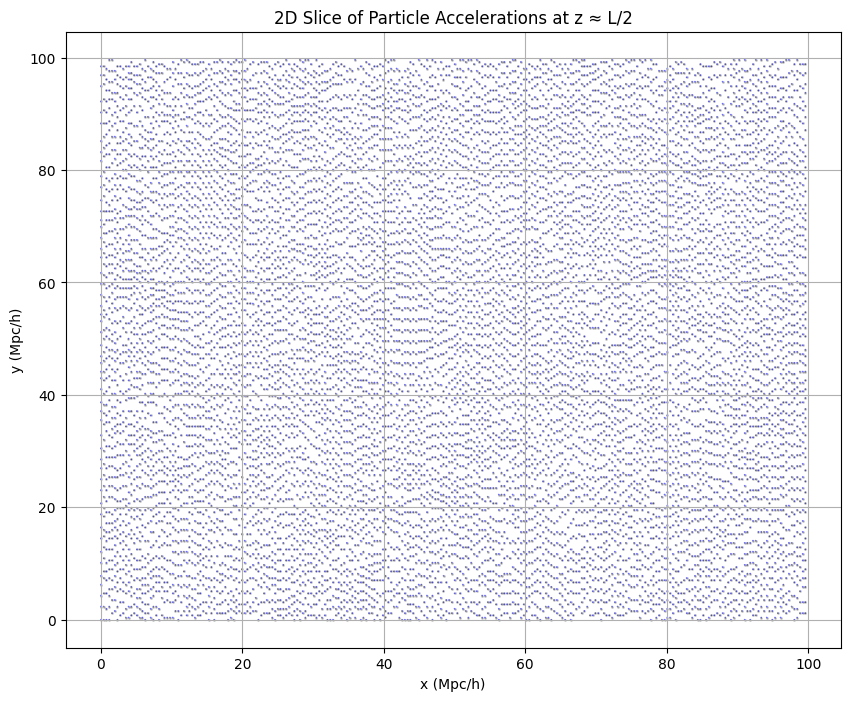

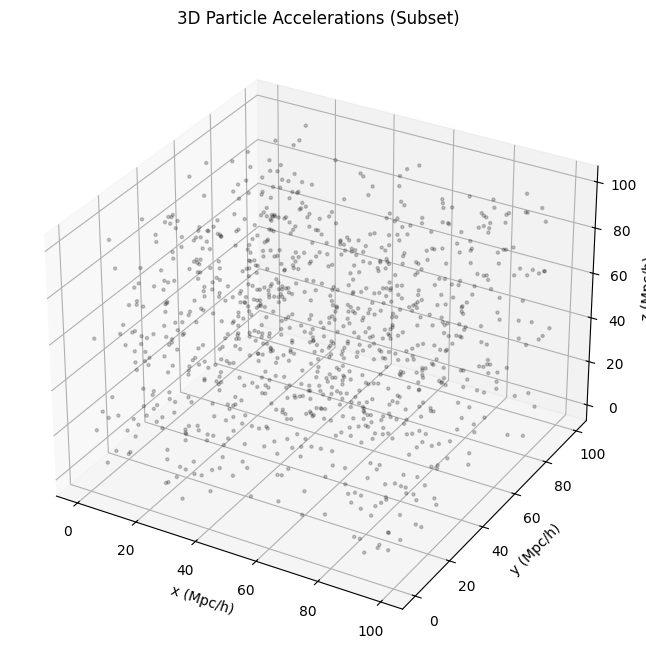

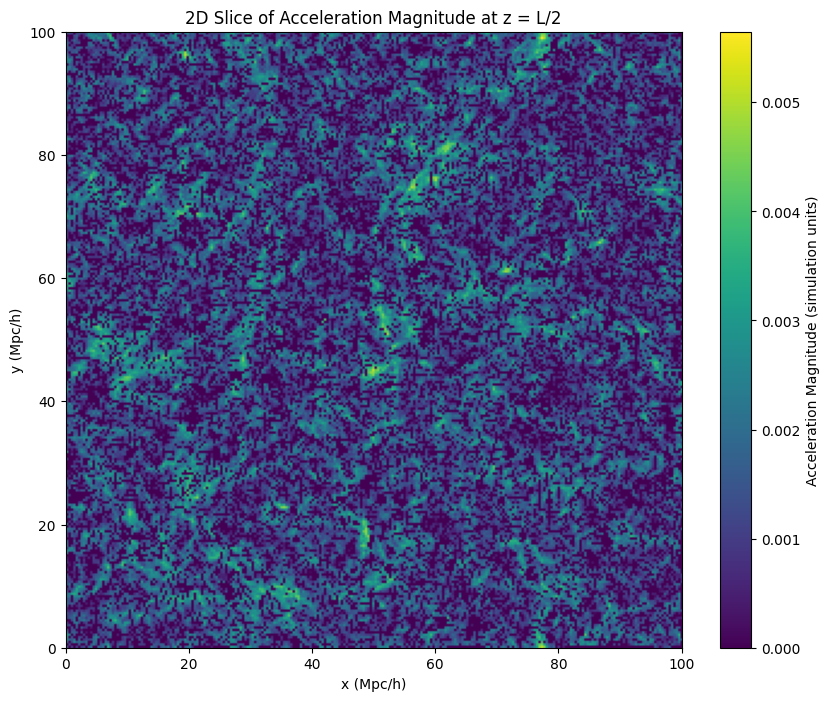

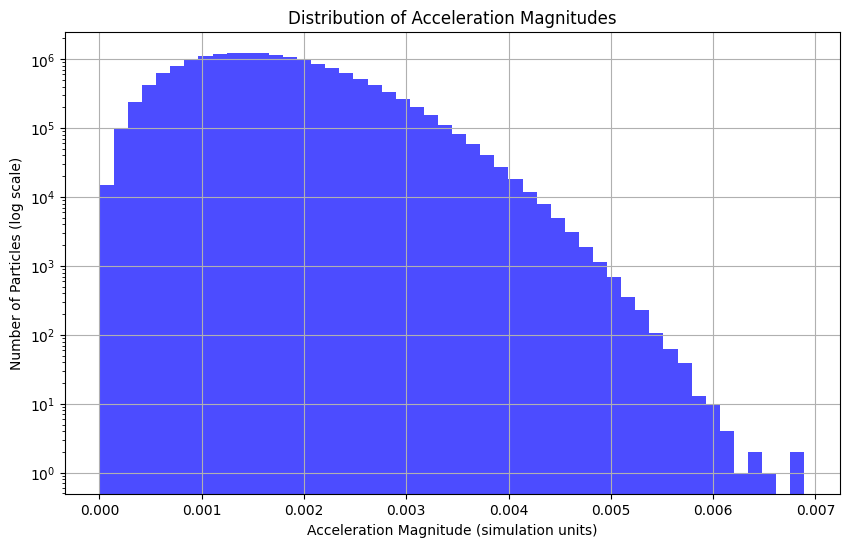

In [ ]:
# Visualizations:

# 2D Scatter with Acceleration Vectors (Quiver Plot):
# Select a 2D slice (e.g., particles near z = L/2)
slice_thickness = L / N  # Grid spacing
z_center = L / 2
mask = (positions[:, 2] > z_center - slice_thickness) & (positions[:, 2] < z_center + slice_thickness)
slice_positions = positions[mask]
slice_accels = a_grav[mask]

# Downsample for clarity (optional, e.g., take every 10th particle)
step = 10
x = slice_positions[::step, 0]
y = slice_positions[::step, 1]
u = slice_accels[::step, 0]  # x-component of acceleration
v = slice_accels[::step, 1]  # y-component

# Create the quiver plot
plt.figure(figsize=(10, 8))
plt.quiver(x, y, u, v, scale=1.0, scale_units='xy', angles='xy', color='blue', alpha=0.5)
plt.scatter(x, y, s=1, color='black', alpha=0.2)  # Particle positions as background
plt.title('2D Slice of Particle Accelerations at z ≈ L/2')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.grid(True)
plt.show()

# 3D Scatter with Acceleration Vectors:
# Subset of particles (e.g., 1000 random ones)
n_subset = 1000
indices = np.random.choice(len(positions), n_subset, replace=False)
subset_pos = positions[indices]
subset_acc = a_grav[indices]

# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(subset_pos[:, 0], subset_pos[:, 1], subset_pos[:, 2],
          subset_acc[:, 0], subset_acc[:, 1], subset_acc[:, 2],
          length=1.0, normalize=False, color='blue', alpha=0.5)
ax.scatter(subset_pos[:, 0], subset_pos[:, 1], subset_pos[:, 2], s=5, color='black', alpha=0.2)
ax.set_title('3D Particle Accelerations (Subset)')
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_zlabel('z (Mpc/h)')
plt.show()

# 2D Acceleration Magnitude Map:
# Compute acceleration magnitudes
accel_magnitude = np.sqrt(np.sum(a_grav**2, axis=1))

# Define a function to grid the magnitudes (similar to CIC but simpler averaging)
def grid_magnitudes(positions, magnitudes, N, L):
    h = L / N
    grid = np.zeros((N, N, N))
    counts = np.zeros((N, N, N))
    indices = (positions / h).astype(int) % N  # Grid indices with periodic boundaries
    np.add.at(grid, (indices[:, 0], indices[:, 1], indices[:, 2]), magnitudes)
    np.add.at(counts, (indices[:, 0], indices[:, 1], indices[:, 2]), 1)
    counts[counts == 0] = 1  # Avoid division by zero
    return grid / counts

# Grid the acceleration magnitudes
accel_grid = grid_magnitudes(positions, accel_magnitude, N, L)

# Plot a 2D slice
plt.figure(figsize=(10, 8))
plt.imshow(accel_grid[N//2, :, :], cmap='viridis', extent=[0, L, 0, L])
plt.colorbar(label='Acceleration Magnitude (simulation units)')
plt.title('2D Slice of Acceleration Magnitude at z = L/2')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Histogram of the Acceleration Magnitudes:
# Compute acceleration magnitudes (if not already done)
accel_magnitude = np.sqrt(np.sum(a_grav**2, axis=1))

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(accel_magnitude, bins=50, log=True, color='blue', alpha=0.7)
plt.title('Distribution of Acceleration Magnitudes')
plt.xlabel('Acceleration Magnitude (simulation units)')
plt.ylabel('Number of Particles (log scale)')
plt.grid(True)
plt.show()


5. ***Leapfrog Integration***
- Using our newly computed accelerations, we can finally start updating our particles' positions and velocities for a certain number of timesteps.
- Firstly, our gravitational acceleration computed thus far (a_grav) is dimensionless (Mpc/h simulation units), and have to be converted to its physical equivalent. We do this via:
  - a cosmological scaling factor on the gravitational accelerations to convert it from a dimensionless acceleration (Mpc/h in our simulation) to a physical acceleration, as well as a 'conversion' factor to put it into physical time units.
  - a 'gravitational_conversion' factor to put the physical acceleration into its physical time units. Have to be represented in time units since Leapfrog Integration is defined as changed in our position and velocities at time intervals Δt.

- Usage of Leapfrog Integration, defined by following steps:
  1. Kick: Updating the velocities by a half-timestep using the current acceleration term.
    - 'hubble param conversion' factor used to convert the Hubble param to its time units equivalent. Used to adequately compute the velocities in km/s.
  2. Drift: Updating the positions by a full-timestep using the half-timestep velocities.
    - scaling of our velocities (physical, peculiar) by 1/a to convert it into its comoving equivalent. This is impoortant, since our position is in comoving units and thus our change in position (which is velocity) have to be as well.
    - eliminating the time units from the new position via the inverse of the 'gravitational_conversion' factor. Making sure periodicity is handled.
  3. Updating the current scaling factor and hubble parameter to be used for the next timestep.
    - simple euler approximation for the scaling update, making sure its dimensionless.
    - updating the hubble parameter using the newly updated scaling factor.
  4. Computing the new accelerations using the newly updated positions.
  5. Kick: Updating the velocities by another half-timestep using the new accelerations computed from the new positions.
  6. Saving the positions to be used for the next timestep.

In [ ]:
# Timestep, measured in million year (Myr), as well as the number of timesteps.
delta_t = 0.1
num_steps = 1000
a_initial = a

In [ ]:
def physical_accelerations(positions, N, L, a_initial, accel_factor):
  cic_density_field = cic_initial(positions, N, L)
  mean_density = np.mean(cic_density_field)
  delta_cic_density_field = cic_density_field / mean_density - 1
  gravitational_forces = zeldovich(delta_cic_density_field)
  accel_x, accel_y, accel_z = cic_grav_force(gravitational_forces[0], positions, N, L), \
                            cic_grav_force(gravitational_forces[1], positions, N, L), \
                            cic_grav_force(gravitational_forces[2], positions, N, L)
  a_grav = np.stack([accel_x, accel_y, accel_z], axis=1)
  physical_accel = a_grav * accel_factor
  return physical_accel

***Simple Leapfrog Integration: Euler's Method***

Leapfrog Integration, using the simple Euler's method for the scaling factor update.
  - first order method, not the best for large timesteps, since it accumulates error proportionally with step size (error $O(Δt^2))$.
$$
a_\text{new} = a_\text{current} + Ha_\text{current}Δt
$$


In [ ]:
# Simple Leapfrog Integration using Euler's Method for the scale factor update.
def leapfrog_euler(positions, velocities, N, L, delta_t, num_steps, a_initial):
  # Reset variables for a fresh start.
  positions_history = [positions.copy()]
  velocities_current = velocities.copy()
  positions_current = positions.copy()
  a_current = a_initial

  # Initial cosmological parameters:
  H_current = Planck18.H(1/a_current - 1).value  # Hubble parameter in km/s/Mpc.
  H0 = Planck18.H0.value
  omega_m = Planck18.Om0
  hubble_conversion = 1.0227e-6
  grav_conversion = 1.45e6
  accel_factor = (3 * H0**2 * omega_m) / (2 * a_current**2) * grav_conversion
  physical_accel = physical_accelerations(positions_current, N, L, a_current, accel_factor)
  print(f"Timestep: {delta_t} Myr")
  print(f"Number of steps: {num_steps}")
  print(f"Initial scale factor a: {a_current:.4f}")
  print(f"Initial Hubble parameter H: {H_current:.2f} km/s/Mpc")
  print(f"Acceleration factor: {accel_factor:.3e} (km/s)/Myr per (Mpc/h)")

  # Integration loop.
  for step in range(num_steps):
    H_Myr = H_current * hubble_conversion  # Convert Hubble parameter to 1/Myr.
    # First Kick (half step)
    accel_term = -(H_Myr * velocities_current) + physical_accel
    velocities_current += accel_term * (delta_t / 2)
    # Drift (full step)
    position_conversion = 1 / grav_conversion
    positions_current += (velocities_current / a_current) * delta_t * position_conversion
    positions_current %= L  # Apply periodic boundary conditions
    # Update scale factor using Euler's method
    a_current += H_Myr * a_current * delta_t
    # Update Hubble parameter
    H_current = Planck18.H(1/a_current - 1).value
    # Compute new accelerations
    accel_factor = (3 * H0**2 * omega_m) / (2 * a_current**2) * grav_conversion
    physical_accel = physical_accelerations(positions_current, N, L, a_current, accel_factor)
    # Second Kick (half step)
    H_Myr = H_current * hubble_conversion
    accel_term = -(H_Myr * velocities_current) + physical_accel
    velocities_current += accel_term * (delta_t / 2)
    # Store current positions
    positions_history.append(positions_current.copy())
    print(f"Euler Step {step+1}: a = {a_current:.6f}, H = {H_current:.2f} km/s/Mpc")

  return positions_history, velocities_current, positions_current

In [ ]:
# Running Euler's Integration:
pos_history_euler, final_velocity_euler, final_position_euler = leapfrog_euler(positions, velocities,
                                                                               N, L, delta_t, num_steps, a_initial)

Timestep: 0.1 Myr
Number of steps: 100
Initial scale factor a: 0.0100
Initial Hubble parameter H: 38244.36 km/s/Mpc
Acceleration factor: 3.083e+13 (km/s)/Myr per (Mpc/h)
Euler Step 1: a = 0.010039, H = 38019.04 km/s/Mpc
Euler Step 2: a = 0.010078, H = 37796.38 km/s/Mpc
Euler Step 3: a = 0.010117, H = 37576.32 km/s/Mpc
Euler Step 4: a = 0.010156, H = 37358.82 km/s/Mpc
Euler Step 5: a = 0.010195, H = 37143.82 km/s/Mpc
Euler Step 6: a = 0.010234, H = 36931.30 km/s/Mpc
Euler Step 7: a = 0.010272, H = 36721.20 km/s/Mpc
Euler Step 8: a = 0.010311, H = 36513.49 km/s/Mpc
Euler Step 9: a = 0.010349, H = 36308.12 km/s/Mpc
Euler Step 10: a = 0.010388, H = 36105.06 km/s/Mpc
Euler Step 11: a = 0.010426, H = 35904.27 km/s/Mpc
Euler Step 12: a = 0.010464, H = 35705.70 km/s/Mpc
Euler Step 13: a = 0.010503, H = 35509.32 km/s/Mpc
Euler Step 14: a = 0.010541, H = 35315.10 km/s/Mpc
Euler Step 15: a = 0.010579, H = 35123.00 km/s/Mpc
Euler Step 16: a = 0.010617, H = 34932.99 km/s/Mpc
Euler Step 17: a = 0.01

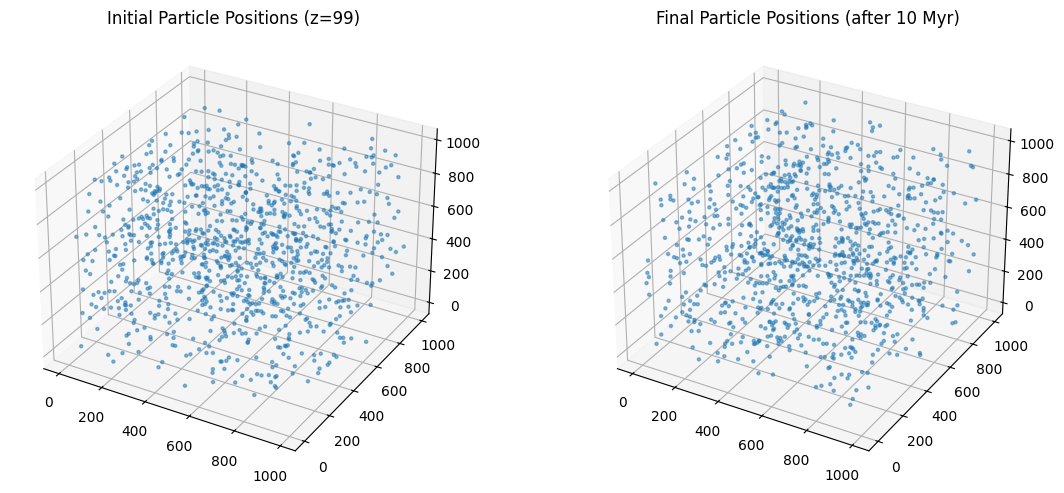

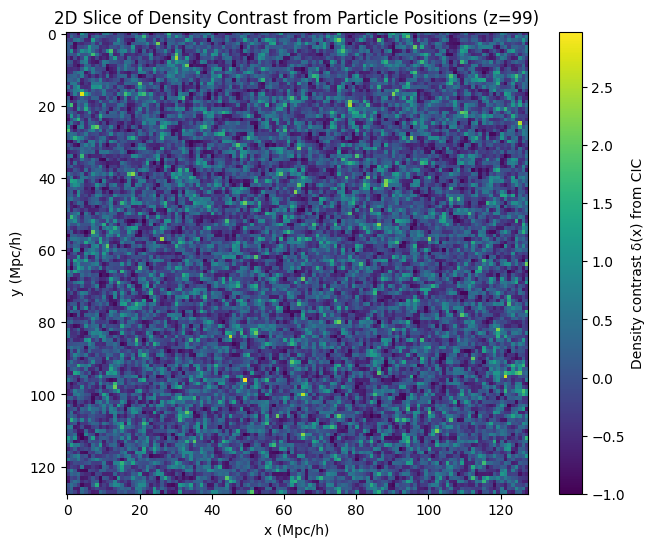

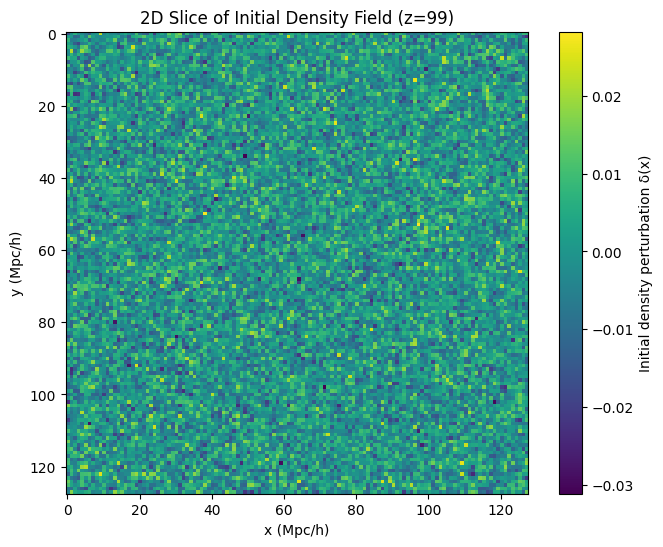

Standard deviation of initial δ: 8.000e-03
Standard deviation of CIC δ: 5.441e-01


In [ ]:
# Visualizations for Euler's Integration:
subset = np.random.choice(len(positions), 1000, replace=False)
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pos_history_euler[0][subset, 0], pos_history_euler[0][subset, 1],
           pos_history_euler[0][subset, 2], s=5, alpha=0.5)
ax1.set_title("Initial Particle Positions (z=99)")
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(final_position_euler[subset, 0], final_position_euler[subset, 1],
           final_position_euler[subset, 2], s=5, alpha=0.5)
ax2.set_title("Final Particle Positions (after 100 Myr)")
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are defined from your simulation:
# - positions_history: list of particle positions at each timestep, with positions_history[-1] being the final positions
# - N: grid size (e.g., 128 for a 128^3 grid)
# - L: physical box size in Mpc/h
# - a_current: final scale factor after the leapfrog integration
# - cic_interpolation: function that computes the density grid from particle positions

# Step 1: Compute the density grid using CIC interpolation from the final particle positions.
density_final = cic_initial(final_position_euler, N, L)

# Step 2: Calculate the mean density
# Total mass is distributed over N^3 grid cells; mean density is total mass / number of cells
mean_density_final = np.sum(density_final) / (N**3)

# Step 3: Compute the density contrast δ(x) = (ρ(x) / ρ_mean) - 1
delta_final = (density_final / mean_density_final) - 1

# Plot a 2D slice of the CIC density contrast
plt.figure(figsize=(8, 6))
plt.imshow(delta_final[N//2, :, :], cmap='viridis')
plt.colorbar(label='Density contrast δ(x) from CIC')
plt.title('2D Slice of Density Contrast from Particle Positions (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()
plt.show()

# Plot the initial density field for comparison
plt.figure(figsize=(8, 6))
plt.imshow(initial_density_field[N//2, :, :], cmap='viridis')
plt.colorbar(label='Initial density perturbation δ(x)')
plt.title('2D Slice of Initial Density Field (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Compare statistics
print(f"Standard deviation of initial δ: {np.std(initial_density_field):.3e}")
print(f"Standard deviation of CIC δ: {np.std(delta_final):.3e}")

***Leapfrog Integration: Runge-Kutta (RK4) Method:***

Leapfrog Integration with Runge-Kutta (RK4) Method for scaling factor updates.
  - fourth-order method, thus more accurate than Euler's (error $O(Δt^5))$
  -

In [ ]:
# Leapfrog Integration using Runge-Kutta (RK4) Method for the scale factor update.
hubble_conversion = 1.0227e-6

# Defining the derivative function for the scaling factor: da/dt = H(a) * a.
def scale_factor_derivative(a):
  z = 1/a - 1
  H = Planck18.H(z).value
  H_Myr = H * hubble_conversion
  return H_Myr * a

def physical_accelerations(positions, N, L, a_initial, accel_factor):
  cic_density_field = cic_initial(positions, N, L)
  mean_density = np.mean(cic_density_field)
  delta_cic_density_field = cic_density_field / mean_density - 1
  gravitational_forces = zeldovich(delta_cic_density_field)
  accel_x, accel_y, accel_z = cic_grav_force(gravitational_forces[0], positions, N, L), \
                            cic_grav_force(gravitational_forces[1], positions, N, L), \
                            cic_grav_force(gravitational_forces[2], positions, N, L)
  a_grav = np.stack([accel_x, accel_y, accel_z], axis=1)
  physical_accel = a_grav * accel_factor
  return physical_accel

def leapfrog_rk4(positions, velocities, N, L, delta_t, num_steps, a_initial):
  # Reset variables for a fresh start.
  positions_history = [positions.copy()]
  velocities_current = velocities.copy()
  positions_current = positions.copy()
  a_current = a_initial

  # Initial cosmological parameters:
  H_current = Planck18.H(1/a_current - 1).value  # Hubble parameter in km/s/Mpc.
  H0 = Planck18.H0.value
  omega_m = Planck18.Om0
  grav_conversion = 1.45e6
  accel_factor = (3 * H0**2 * omega_m) / (2 * a_current**2) * grav_conversion
  physical_accel = physical_accelerations(positions_current, N, L, a_current, accel_factor)
  print(f"Timestep: {delta_t} Myr")
  print(f"Number of steps: {num_steps}")
  print(f"Initial scale factor a: {a_current:.4f}")
  print(f"Initial Hubble parameter H: {H_current:.2f} km/s/Mpc")
  print(f"Acceleration factor: {accel_factor:.3e} (km/s)/Myr per (Mpc/h)")

  for step in range(num_steps):
    H_Myr = H_current * hubble_conversion # Convert Hubble parameter to 1/Myr.
    # First Kick (half step)
    accel_term = -(H_Myr * velocities_current) + physical_accel
    velocities_current += accel_term * (delta_t / 2)
    # Drift (full step)
    position_conversion = 1 / grav_conversion
    positions_current += (velocities_current / a_current) * delta_t * position_conversion
    positions_current %= L  # Apply periodic boundary conditions

    # Updating the scale factor using RK4:
    k1 = scale_factor_derivative(a_current)
    k2 = scale_factor_derivative(a_current + (delta_t / 2) * k1)
    k3 = scale_factor_derivative(a_current + (delta_t / 2) * k2)
    k4 = scale_factor_derivative(a_current + delta_t * k3)
    a_current += (delta_t / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    # Update Hubble parameter
    H_current = Planck18.H(1/a_current - 1).value
    # Compute new accelerations
    accel_factor = (3 * H0**2 * omega_m) / (2 * a_current**2) * grav_conversion
    physical_accel = physical_accelerations(positions_current, N, L, a_current, accel_factor)
    # Second kick (half step)
    H_Myr = H_current * hubble_conversion
    accel_term = -(H_Myr * velocities_current) + physical_accel
    velocities_current += accel_term * (delta_t / 2)
    # Store current positions
    positions_history.append(positions_current.copy())
    print(f"RK4 Step {step+1}: a = {a_current:.6f}, H = {H_current:.2f} km/s/Mpc")

  return positions_history, velocities_current, positions_current

In [ ]:
# Run RK4 integration (starts fresh, no interference from Euler run)
pos_history_rk4, final_velocity_rk4, final_position_rk4 = leapfrog_rk4(
    positions, velocities, N, L, delta_t, num_steps, a_initial
)

Timestep: 0.1 Myr
Number of steps: 100
Initial scale factor a: 0.0100
Initial Hubble parameter H: 38244.36 km/s/Mpc
Acceleration factor: 3.083e+13 (km/s)/Myr per (Mpc/h)
RK4 Step 1: a = 0.010039, H = 38019.27 km/s/Mpc
RK4 Step 2: a = 0.010078, H = 37796.82 km/s/Mpc
RK4 Step 3: a = 0.010117, H = 37576.98 km/s/Mpc
RK4 Step 4: a = 0.010156, H = 37359.68 km/s/Mpc
RK4 Step 5: a = 0.010195, H = 37144.88 km/s/Mpc
RK4 Step 6: a = 0.010233, H = 36932.55 km/s/Mpc
RK4 Step 7: a = 0.010272, H = 36722.64 km/s/Mpc
RK4 Step 8: a = 0.010310, H = 36515.11 km/s/Mpc
RK4 Step 9: a = 0.010349, H = 36309.92 km/s/Mpc
RK4 Step 10: a = 0.010387, H = 36107.03 km/s/Mpc
RK4 Step 11: a = 0.010426, H = 35906.40 km/s/Mpc
RK4 Step 12: a = 0.010464, H = 35708.00 km/s/Mpc
RK4 Step 13: a = 0.010502, H = 35511.78 km/s/Mpc
RK4 Step 14: a = 0.010540, H = 35317.71 km/s/Mpc
RK4 Step 15: a = 0.010578, H = 35125.76 km/s/Mpc
RK4 Step 16: a = 0.010616, H = 34935.89 km/s/Mpc
RK4 Step 17: a = 0.010654, H = 34748.07 km/s/Mpc
RK4 St

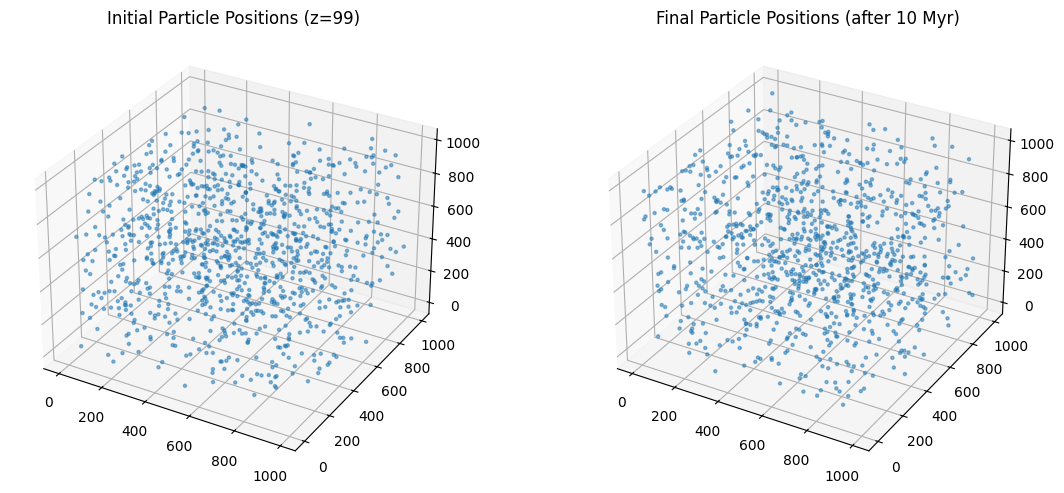

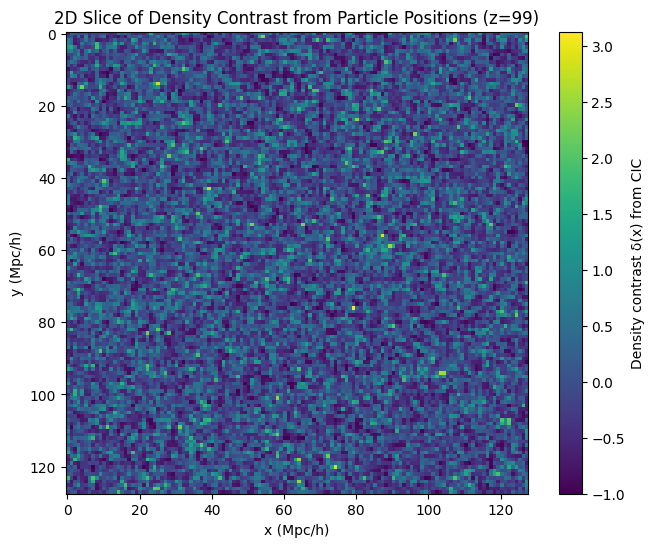

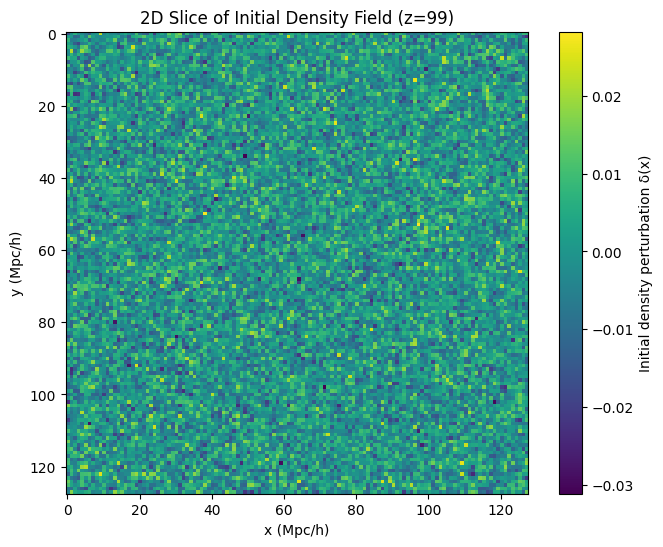

Standard deviation of initial δ: 8.000e-03
Standard deviation of CIC δ: 5.441e-01


In [ ]:
# Visualizations for RK4's Integration:
subset = np.random.choice(len(positions), 1000, replace=False)
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pos_history_rk4[0][subset, 0], pos_history_rk4[0][subset, 1],
           pos_history_rk4[0][subset, 2], s=5, alpha=0.5)
ax1.set_title("Initial Particle Positions (z=99)")
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(final_position_rk4[subset, 0], final_position_rk4[subset, 1],
           final_position_rk4[subset, 2], s=5, alpha=0.5)
ax2.set_title("Final Particle Positions (after 100 Myr)")
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are defined from your simulation:
# - positions_history: list of particle positions at each timestep, with positions_history[-1] being the final positions
# - N: grid size (e.g., 128 for a 128^3 grid)
# - L: physical box size in Mpc/h
# - a_current: final scale factor after the leapfrog integration
# - cic_interpolation: function that computes the density grid from particle positions

# Step 1: Compute the density grid using CIC interpolation from the final particle positions.
density_final = cic_initial(final_position_rk4, N, L)

# Step 2: Calculate the mean density
# Total mass is distributed over N^3 grid cells; mean density is total mass / number of cells
mean_density_final = np.sum(density_final) / (N**3)

# Step 3: Compute the density contrast δ(x) = (ρ(x) / ρ_mean) - 1
delta_final = (density_final / mean_density_final) - 1

# Plot a 2D slice of the CIC density contrast
plt.figure(figsize=(8, 6))
plt.imshow(delta_final[N//2, :, :], cmap='viridis')
plt.colorbar(label='Density contrast δ(x) from CIC')
plt.title('2D Slice of Density Contrast from Particle Positions (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()
plt.show()

# Plot the initial density field for comparison
plt.figure(figsize=(8, 6))
plt.imshow(initial_density_field[N//2, :, :], cmap='viridis')
plt.colorbar(label='Initial density perturbation δ(x)')
plt.title('2D Slice of Initial Density Field (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Compare statistics
print(f"Standard deviation of initial δ: {np.std(initial_density_field):.3e}")
print(f"Standard deviation of CIC δ: {np.std(delta_final):.3e}")